# Active Aero Arduino Project

## Welcome to my active aero project! Here, I'll be explaining all the ins and outs of this project, Ive also added in my exact code!

### 0.1 Abstract





Here is the plot produced by adjusting the target and recording the PID response and hence, the simulated pitch:

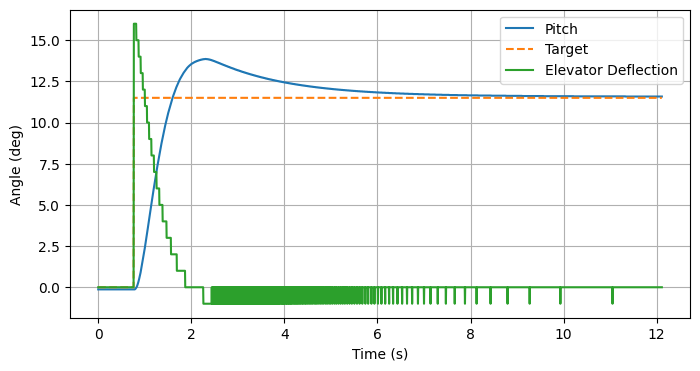

Overshoot: inf%


C:\Users\tyres\AppData\Local\Temp\ipykernel_83088\1287199327.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  overshoot_pct = (peak - target_val) / target_val * 100


In [5]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt(r"C:\Users\tyres\OneDrive\Documents\Arduino\Arduino stuff\log.txt", delimiter=",")

t = (data[:,0] - 23360) / 1000.0   # ms → s
target = data[:,1]
pitch = data[:,2]
elev = data[:,3]

plt.figure(figsize=(8,4))
plt.plot(t, pitch, label=" Simulated Pitch")
plt.plot(t, target, "--", label="Target")
plt.plot(t, elev, label="Elevator Deflection")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.legend()
plt.grid(True)
plt.show()
#--------- BELOW IS A CALCULATION OF THE PRECISE OVERSHOOT PERCENTAGE -----------
peak = np.max(pitch)
target_val = target[0]
overshoot_pct = (peak - target_val) / target_val * 100

print(f"Overshoot: {overshoot_pct:.1f}%")

